In [16]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [8]:
!nvidia-smi

Mon May 12 15:11:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
!pip install -q rfdetr==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 890.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [12]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/ai-qrccw/my-first-project-i9qhe/dataset/25", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-25 in coco:: 100%|██████████| 279/279 [00:00<00:00, 3622.01it/s]


In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(dataset_dir=dataset.location, epochs=100, batch_size=4, grad_accum_steps=4, lr=1e-4)

Loading pretrain weights


reinitializing your detection head with 53 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=53, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=100, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads

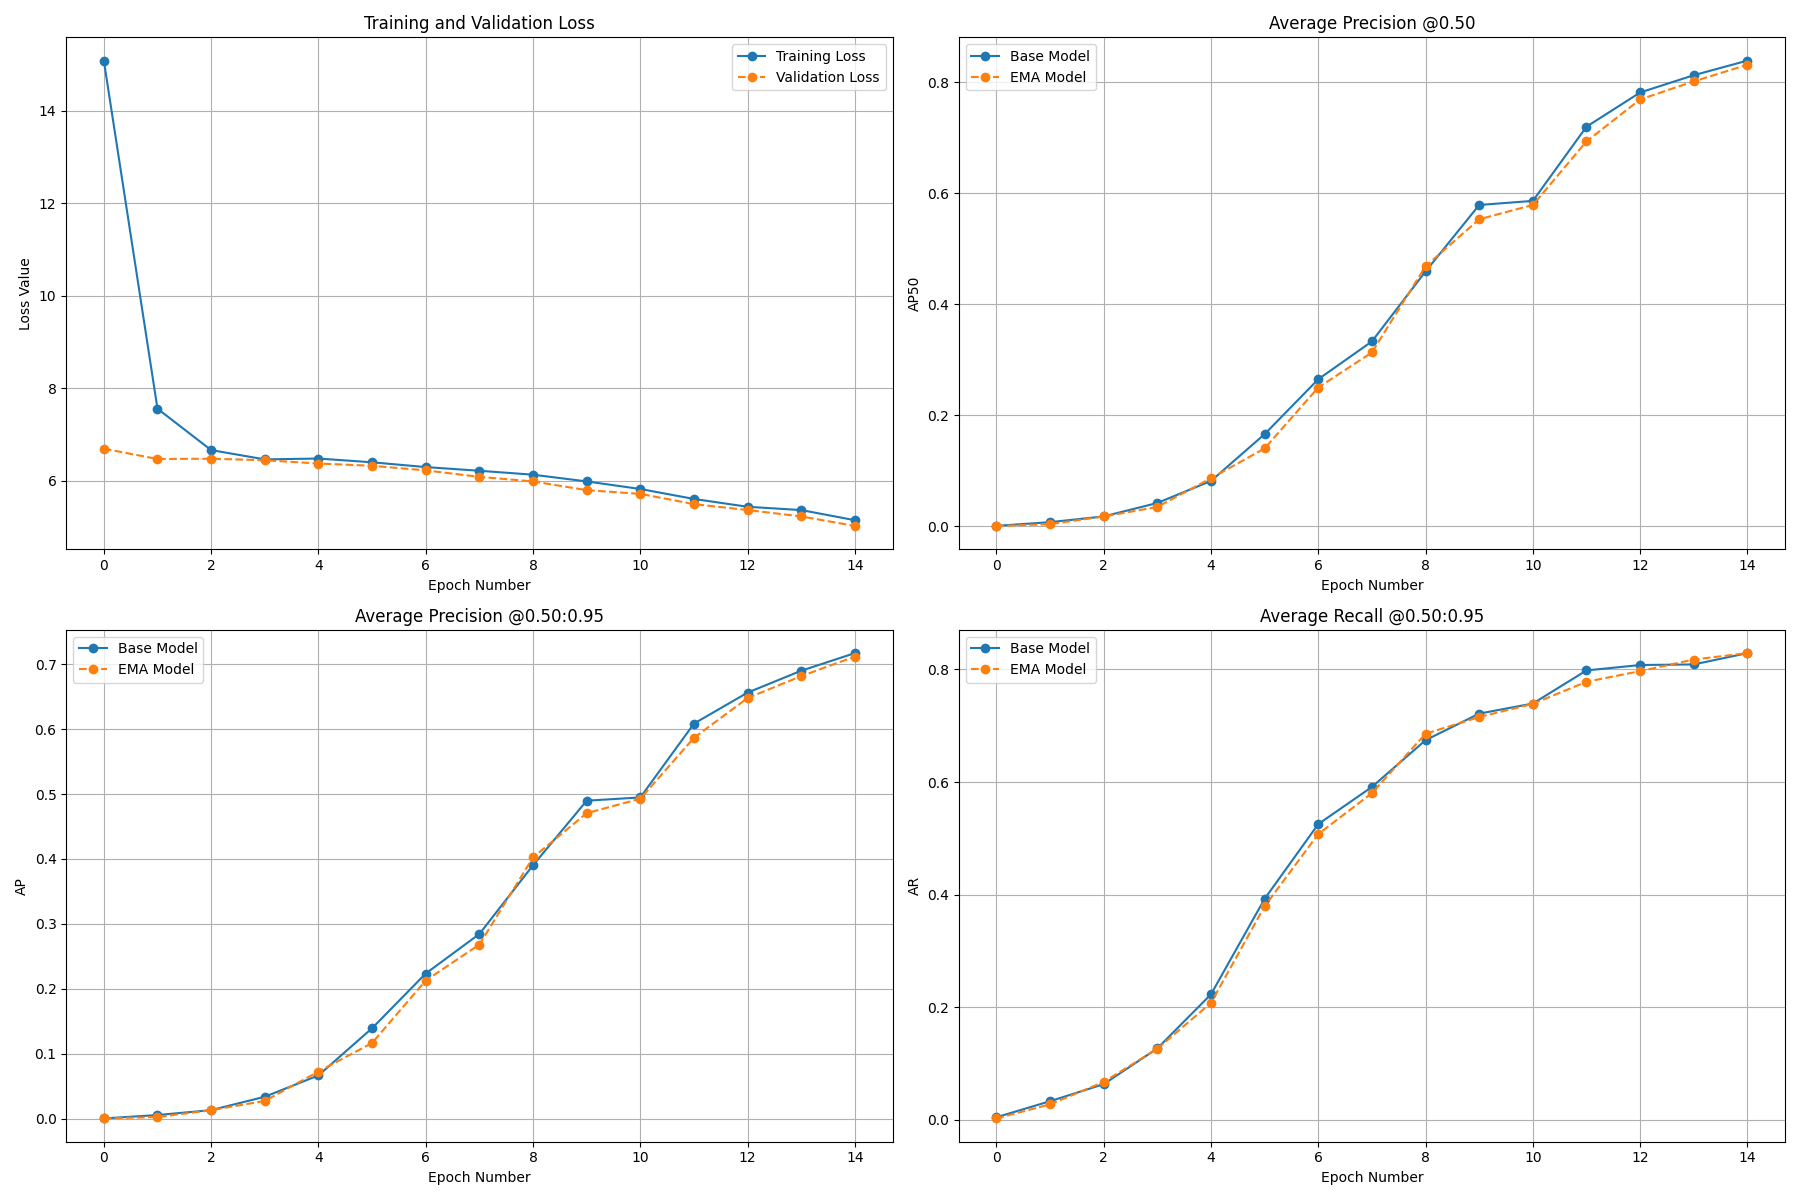

In [18]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

## Run inference with fine-tuned model

In [21]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

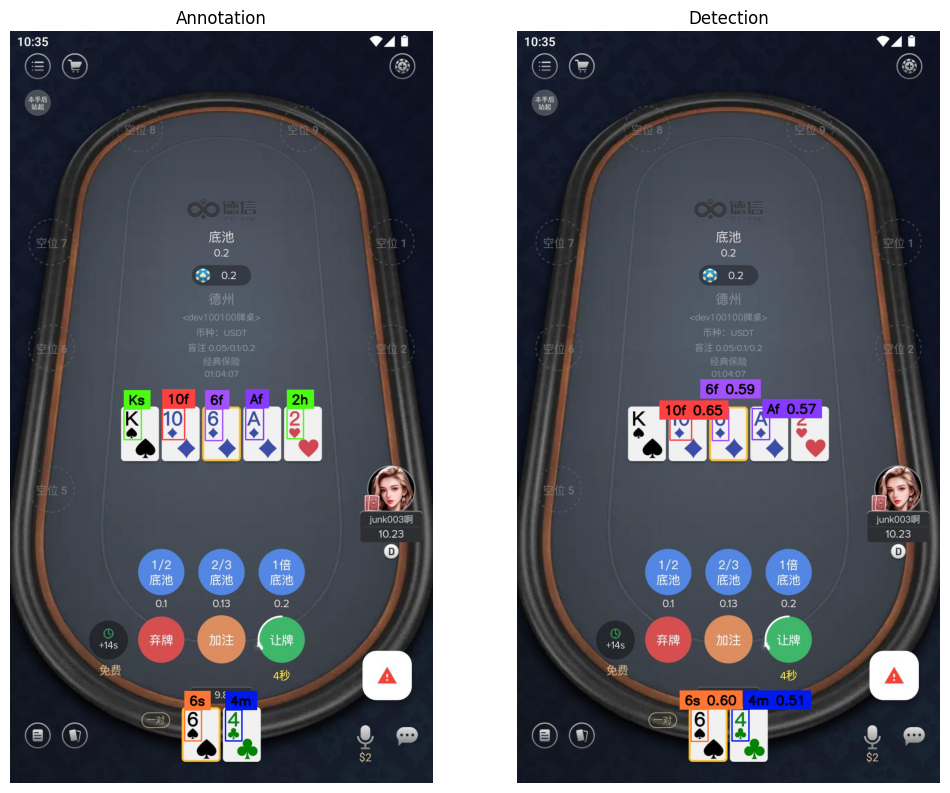

In [22]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

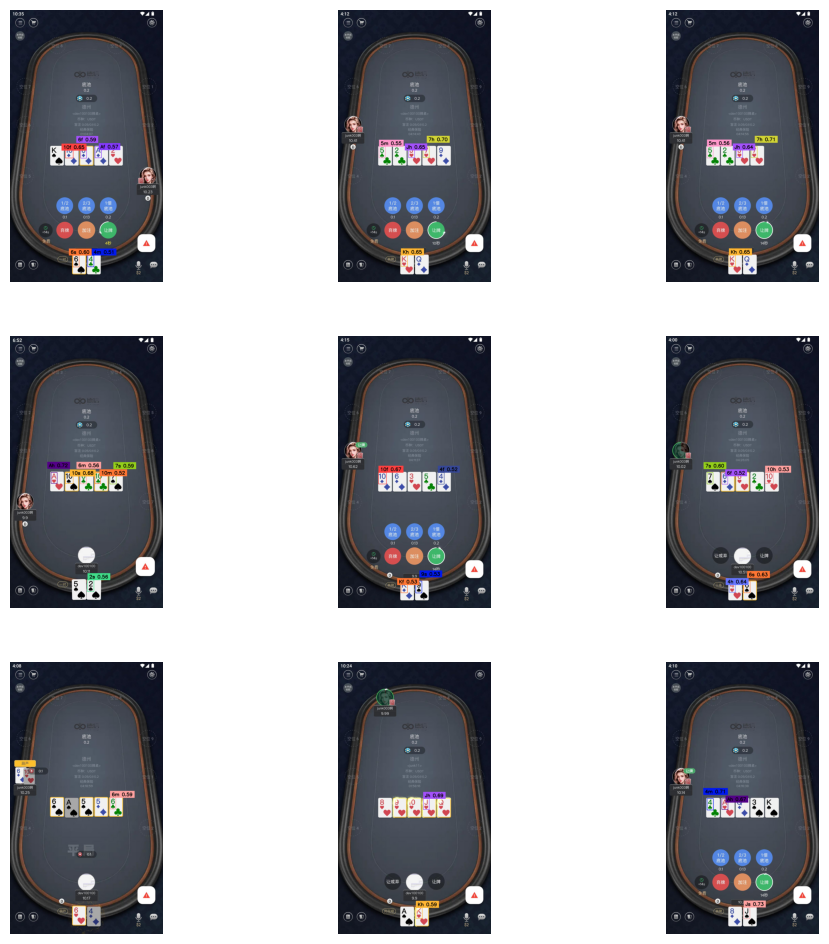

In [23]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate fine-tuned model

In [24]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 29/29 [00:02<00:00, 14.13it/s]


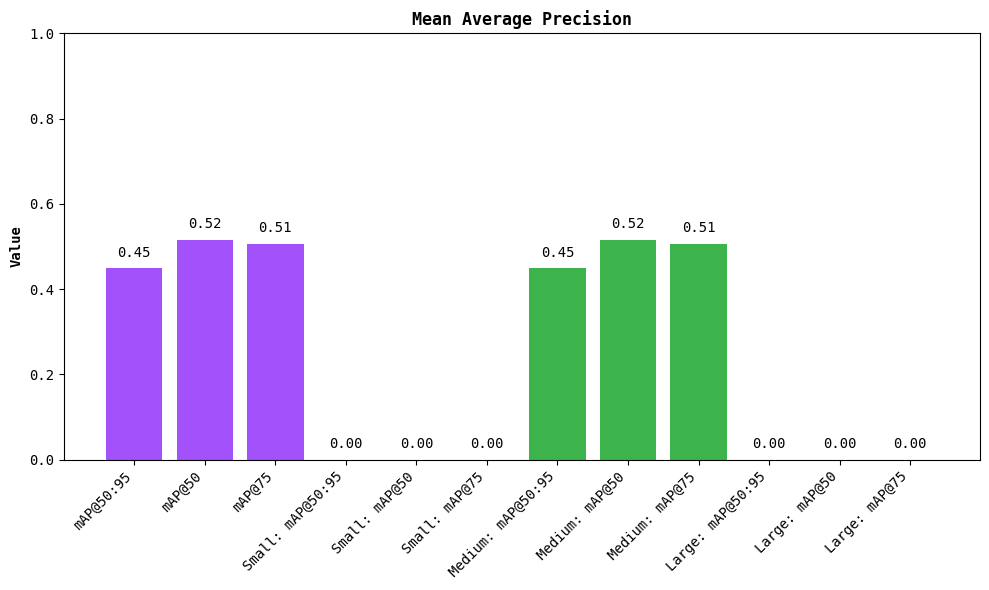

In [25]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

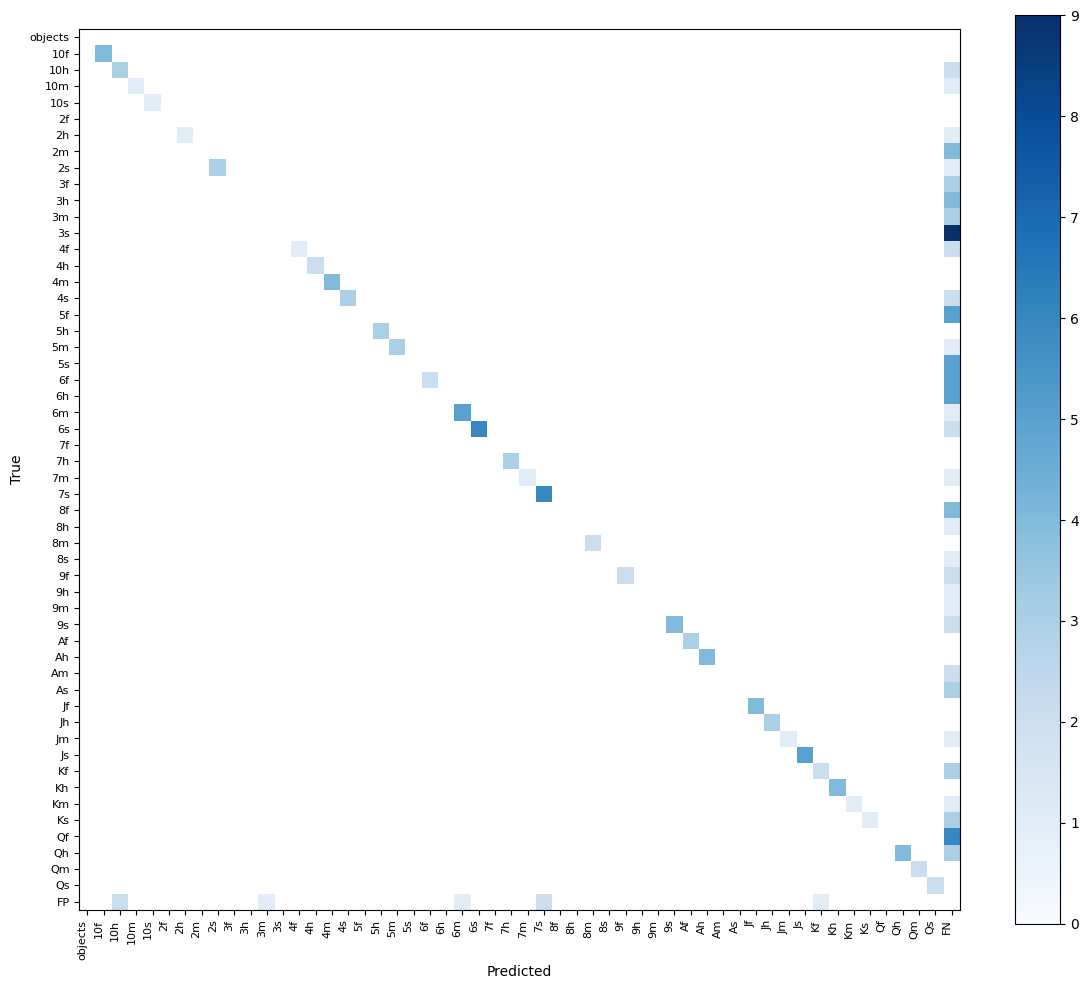

In [26]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot()